# Tutorial

In [26]:
import monkeybread as mb
import scanpy as sc
import pandas as pd
import subprocess
import matplotlib.pyplot as plt

sc.settings.verbosity = 3

In [2]:
subprocess.run(
    "mkdir data", 
    shell = True
)
subprocess.run(
    "gsutil -m cp -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_by_gene.csv \
    gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_metadata.csv \
    ./data/", 
    shell = True
)

CompletedProcess(args='gsutil -m cp -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_by_gene.csv     gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_metadata.csv     ./data/', returncode=0)

In [3]:
# OPTIONAL: To use cell_transcript_proximity functions
subprocess.run(
    "gsutil -m cp -r -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/detected_transcripts.csv \
    gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_boundaries/ \
    ./data/", 
    shell = True
)

CompletedProcess(args='gsutil -m cp -r -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/detected_transcripts.csv     gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_boundaries/     ./data/', returncode=0)

The above downloads data from Vizgen's [MERSCOPE FFPE data release](https://info.vizgen.com/ffpe-showcase), in particular one of the Ovarian Cancer samples. Due to the large size of transcript and cell boundary files, the smallest sample was selected for the tutorial.

In [17]:
# No need to specify custom file paths, this function will read in all relevant files in the directory provided.
adata = mb.util.load_merscope("./data")

... reading from cache file cache\data-cell_by_gene.h5ad


Perform some standard preprocessing on the data

In [18]:
sc.pp.filter_cells(adata, min_counts = 50, inplace = True)
sc.pp.normalize_total(adata, target_sum = 1000000, inplace = True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added = "clusters")

filtered out 6770 cells that have less than 50 counts
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:11)
running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:01:06)


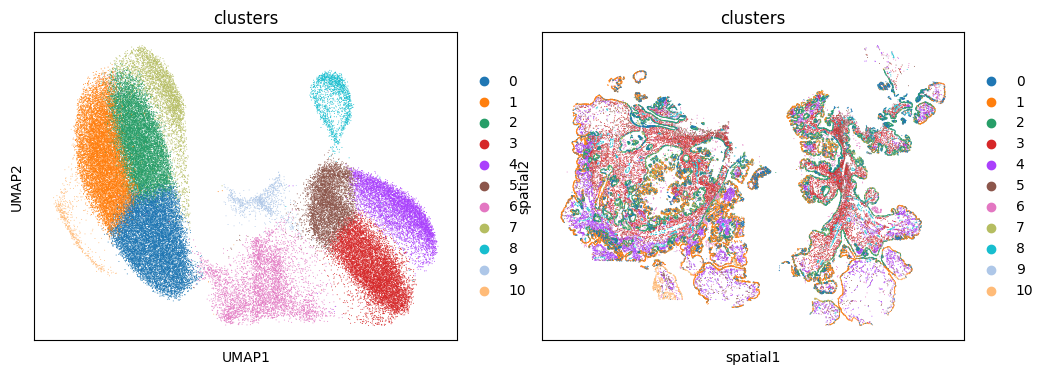

In [28]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sc.pl.embedding(
    adata,
    "umap",
    color = "clusters",
    ax = axs[0],
    show = False
)
sc.pl.embedding(
    adata,
    "spatial",
    color = "clusters",
    ax = axs[1],
    show = True
)

## Cell Proximity Analyses

Monkeybread provides several ways to investigate cell proximity in spatial data.

### Kernel Density Estimation

[Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) is a method for generating an approximate distribution to estimate density of values of interest. In spatial data, we can use the same principle to determine density of cell properties, such as cell type.

C:\Users\Dillon Scott\monkeybread\venv\lib\site-packages\monkeybread\calc\_kernel_density.py:73: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(distances / bandwidth))


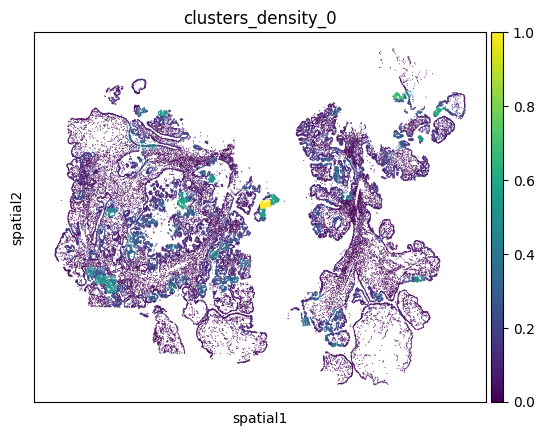

In [66]:
density_key = mb.calc.kernel_density(
    adata,
    groupby = "clusters",
    group = "0",
    resolution = 4
)
mb.plot.kernel_density(
    adata,
    key = density_key
)

### Shortest Distances

The shortest distance approach measures the distance from each member of `group1` to the closest member of `group2`.

In [ ]:
distances = mb.calc.shortest_distances(
    adata,
    groupby = "clusters",
    group1 = "0",
    group2 = ["2", "3"]
)
mb.plot.shortest_distances(distances)

The statistical test performed here permutes the labels in `groupby` for all cells not in `group2`, then reruns the shortest distances function to generate a null distribution.

In [ ]:
permutation_distances = mb.stat.shortest_distances(
    adata,
    groupby = "clusters",
    group1 = "0",
    group2 = ["2", "3"]
)
mb.plot.shortest_distances(distances, expected_distances = permutation_distances)

### Cell Contact

Cell contact detects cells within either a provided or automatically generated radius of each other.

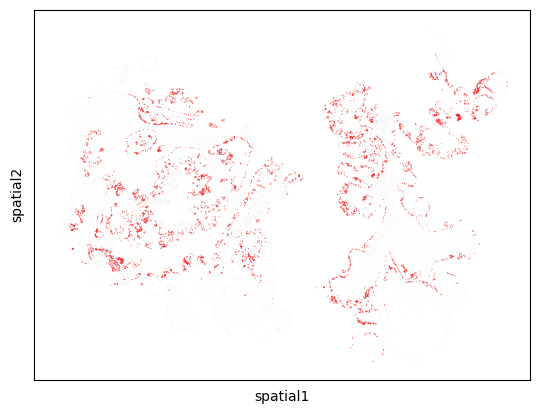

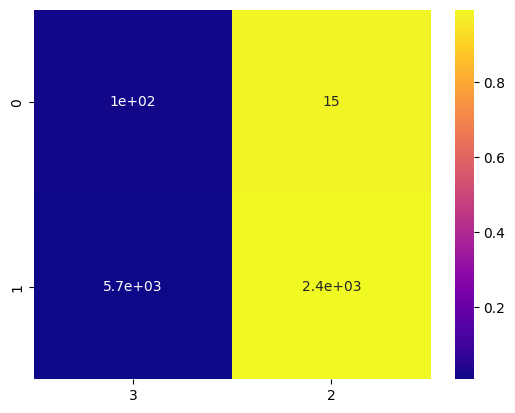

In [72]:
### TODO: Make into subplots
observed_contacts = mb.calc.cell_contact(
    adata,
    groupby = "clusters",
    group1 = ["0", "1"],
    group2 = ["2", "3"]
)
mb.plot.cell_contact_embedding(
    adata,
    observed_contacts,
    show = True
)
mb.plot.cell_contact_heatmap(
    adata,
    "clusters",
    observed_contacts,
    show = True
) ## TODO Adjust formatting of heatmap and look into coloring issue

The statistical test performed here assigns each cell in `group1` and `group2` a new location within a certain radius of its original location (default 100 microns), then reruns the cell contact function to generate a null distribution.

In [ ]:
permutation_contacts_grouped = mb.stat.cell_contact(
    adata,
    groupby = "clusters",
    group1 = ["0", "1"],
    group2 = ["2", "3"],
    actual_contact = observed_contacts,
    n_perms = 100,
    contact_radius = 15,
)
mb.plot.cell_contact_histplot(
    adata,
    observed_contacts,
    expected_contacts = permutation_contacts_grouped
)

By setting the `split_groups` argument to `True`, the statistical test will be performed pairwise across `group1` and `group2` instead of aggregating groups. This approach is more efficient than running the function individually for each pairwise comparison.

In [78]:
permutation_contacts_split = mb.stat.cell_contact(
    adata,
    groupby = "clusters",
    group1 = ["0", "1"],
    group2 = ["2", "3"],
    actual_contact = observed_contacts,
    n_perms = 100,
    contact_radius = 15,
    split_groups = True
)
mb.plot.cell_contact_heatmap(
    adata,
    observed_contacts,
    expected_contacts = permutation_contacts_split
)

MemoryError: Unable to allocate 89.7 MiB for an array with shape (42736, 550) and data type float32

DE analysis can be performed between cells with observed contact and cells in the same group without observed contact, in accordance with the following structure:

In [79]:
adata.obs["touching"] = pd.Categorical([cell in observed_contacts for cell in adata.obs.index])
sc.tl.rank_genes_groups(
    adata,
    groupby = "touching",
    use_raw = False
)

ranking genes


MemoryError: Unable to allocate 33.9 MiB for an array with shape (64611, 550) and data type bool

Monkeybread also exposes a [volcano plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)) function for observing results of a DE analysis.

In [ ]:
mb.plot.volcano_plot(
    adata,
    group = True
)

### Cell Transcript Observations

If `detected_transcripts.csv` and `cell_boundaries/` are present in the folder loaded by `load_merscope`, you can use some additional functions to view data at the cellular and transcriptional level.

In [ ]:
cell_ids = list(observed_contacts.keys())[0]
cell_ids.extend(observed_contacts[cell_ids[0]])
transcript_proximity_df = mb.calc.cell_transcript_proximity(
    adata,
    cell_ids
)
mb.plot.cell_transcript_proximity(
    adata,
    cell_ids,
    transcript_proximity_df
)

### Other Utility Functions

The below function allows for subsetting an AnnData object based on spatial location and/or gene counts. When subsetting by spatial location, this allows for "zooming in" on portions of the dataset.

In [ ]:
adata_zoomed = mb.util.subset_cells(
    adata,
    by = "spatial",
    subset = [
        ("x", "lte", 3000),
        ("x", "gte", 2000),
        ("y", "lte", 3000),
        ("y", "gte", 2000)
    ]
)

You can then perform any other analyses using the new `adata` object.

In [ ]:
zoomed_contact = mb.calc.cell_contact(
    adata_zoomed,
    groupby = "clusters",
    group1 = [0, 1],
    group2 = [2, 3]
)

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
sc.pl.embedding(
    adata, 
    basis = "spatial", 
    color = "clusters",
    ax = axs[0][0], 
    show = False,
)
rect = mpl.patches.Rectangle((2000, 2000), 1000, 1000, linewidth=1, edgecolor='r', facecolor='none')
axs[0][0].add_patch(rect)
mb.plot.cell_contact_embedding(
    adata, 
    observed_contacts, 
    color = "clusters", 
    ax = axs[0][1]
)
rect = mpl.patches.Rectangle((2000, 2000), 1000, 1000, linewidth=1, edgecolor='r', facecolor='none')
axs[0][1].add_patch(rect)
sc.pl.embedding(
    adata_zoomed, 
    basis = "spatial", 
    color = "clusters",
    ax = axs[1][0], 
    show = False,
)
mb.plot.cell_contact_embedding(
    adata_zoomed, 
    zoomed_contact, 
    color = "clusters", 
    ax = axs[1][1]
)
plt.tight_layout()
plt.show()